# 🧠 Building an Expected Goals (xG) Model
This notebook processes football shot data to train an expected goals (xG) model using logistic regression.

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, classification_report, make_scorer
from mplsoccer import Pitch
from matplotlib.colors import LinearSegmentedColormap
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load data
file_path = os.path.expanduser(r'C:\Users\Administrator\Desktop\XGoal/xg_model.csv')
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {file_path}")


In [22]:
print("Initial shape:", df.shape)
print(df[['x', 'y']].agg(['min', 'max']))
print("Missing values:\n", df.isna().sum())

# Drop irrelevant or unwanted columns
cols_to_drop = ['DirectFreekick', 'DirectCorner', 'OwnGoal']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Drop own goals if still present
df = df[df.get('OwnGoal') != True] if 'OwnGoal' in df else df

# Fill NaNs
df.fillna(0, inplace=True)


Initial shape: (8118, 25)
        x     y
min   0.8   3.1
max  99.6  99.6
Missing values:
 x                     0
y                     0
is_goal               0
period                0
Assisted           2080
Zone                  0
IndividualPlay     5316
RegularPlay        2728
LeftFoot           5327
RightFoot          4124
FromCorner         6924
FirstTouch         4193
Head               6818
BigChance          6511
SetPiece           7725
Volley             7308
FastBreak          7502
ThrowinSetPiece    7930
Penalty            8012
OneOnOne           7917
KeyPass            8060
DirectFreekick     7887
OwnGoal            8091
OtherBodyPart      8085
DirectCorner       8116
dtype: int64


In [23]:
# Cast to appropriate types
df = df.astype({
    'x': float, 'y': float, 'is_goal': bool, 'period': str,
    'Assisted': bool, 'Zone': str, 'IndividualPlay': bool, 'RegularPlay': bool,
    'LeftFoot': bool, 'RightFoot': bool, 'FromCorner': bool, 'FirstTouch': bool,
    'Head': bool, 'BigChance': bool, 'SetPiece': bool, 'Volley': bool,
    'FastBreak': bool, 'ThrowinSetPiece': bool, 'Penalty': bool,
    'OneOnOne': bool, 'KeyPass': bool, 'OtherBodyPart': bool
}, errors='ignore')


In [24]:
# Shot distance from goal (100, 50)
df["shot_distance"] = np.hypot(df["x"] - 100, df["y"] - 50)


In [25]:
df = pd.get_dummies(df, columns=["period", "Zone"], drop_first=True)


In [26]:
X = df.drop('is_goal', axis=1)
y = df['is_goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Log Loss:", log_loss(y_test, y_pred_proba))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("Brier Score:", brier_score_loss(y_test, y_pred_proba))


Log Loss: 0.2837289055159535
ROC AUC: 0.7909105076005497
Brier Score: 0.08170485029227209


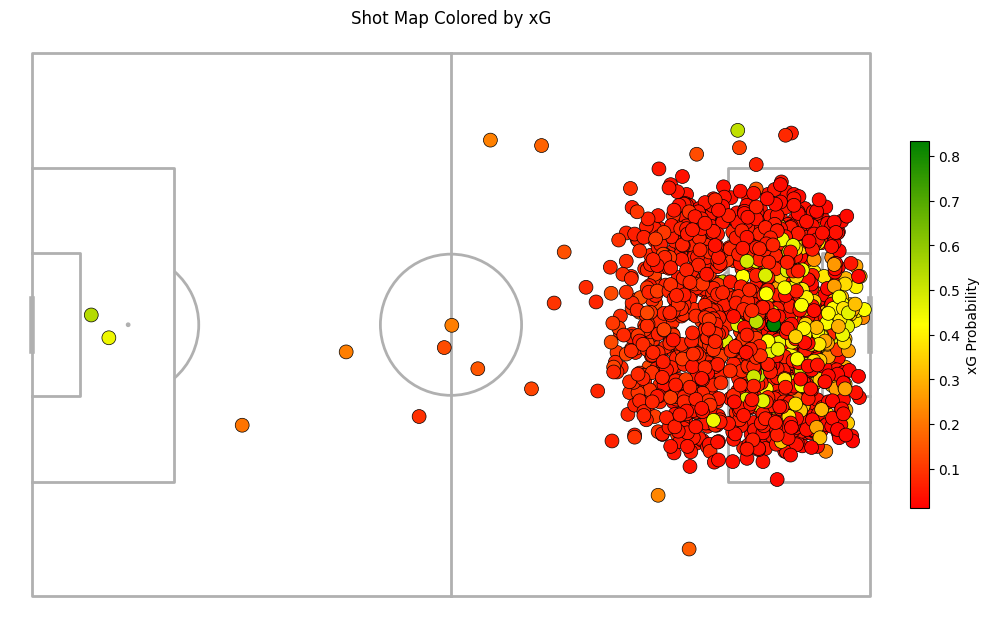

In [28]:
final_df = X_test.copy()
final_df['goal_probability'] = y_pred_proba

pitch = Pitch(pitch_type='opta')
colors = ['red', 'yellow', 'green']
cmap = LinearSegmentedColormap.from_list('xg_cmap', colors)

fig, ax = pitch.draw(figsize=(10, 8))
sc = pitch.scatter(final_df['x'], final_df['y'], c=final_df['goal_probability'],
                   cmap=cmap, edgecolors='black', linewidth=0.5, s=100, ax=ax)
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label('xG Probability')
plt.title('Shot Map Colored by xG')
plt.tight_layout()
plt.show()


In [29]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000]
}

scorer = make_scorer(roc_auc_score, needs_proba=True)
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score (CV):", grid_search.best_score_)
print("Test ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

y_pred = (y_pred_proba > 0.5).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best ROC AUC Score (CV): nan
Test ROC AUC Score: 0.7729698811395866

Classification Report:
               precision    recall  f1-score   support

       False       0.88      1.00      0.94      1426
        True       0.00      0.00      0.00       198

    accuracy                           0.88      1624
   macro avg       0.44      0.50      0.47      1624
weighted avg       0.77      0.88      0.82      1624

